In [173]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import defaultdict
import numpy as np
import pandas as pd
import unicodedata
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, bigrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
import nltk.collocations as collocations
from nltk.util import ngrams


import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score,  confusion_matrix, ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import datasets, layers, models, callbacks
from kerastuner.tuners import RandomSearch
from keras import backend as K
from imblearn.over_sampling import RandomOverSampler

nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danayt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/danayt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/danayt/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/danayt/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/danayt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [174]:
# !pip install wordcloud

In [175]:
import sklearn
sklearn.__version__

'1.3.1'

In [176]:
# !pip install keras-tuner

In [177]:
data = pd.read_csv("./raw_data/judge-1377884607_tweet_product_company.csv", encoding='unicode_escape')

In [178]:
# dopping null column from tweet_text column since it's only one and has no information for our analysis
data.tweet_text.isna().sum()
data.dropna(subset=['tweet_text'], inplace=True)

In [179]:
# looking at our .describe, there seems to be some duplicates in our data and we'll go ahead and keep unique inputs only
data.drop_duplicates(subset=['tweet_text'], inplace=True)

In [180]:
# Creating a cleaned emotion_in tweet_is_directed_at column
data.rename(columns={'emotion_in_tweet_is_directed_at': 'brand'}, inplace=True)
data.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

In [181]:
keywords = ["Apple", "Google", "iPad", "iPhone", "Android", "goog"]

for keyword in keywords:
    data[keyword] = data['tweet_text'].str.extract(f'({keyword})', flags=re.IGNORECASE)

data['product'] = data[['Apple', 'iPhone', 'iPad', 'Google', 'Android']].apply(lambda x: 'Apple' if x[['Apple', 'iPhone', 'iPad']].any() 
                                                                                else 'Google' if x[['Google', 'Android']].any() 
                                                                                else None, axis=1)

In [182]:
data['product'].value_counts()

product
Apple     5517
Google    2764
Name: count, dtype: int64

In [183]:
# Since we've classified our product column, we'll drop nulls as we're interested with apple and google products
data['product'].isna().sum()

784

In [184]:
#Dropped to focus on tweets where google and apple where mentioned
data.dropna(subset=['product'], inplace=True)

In [185]:
data['sentiment'].replace("I can't tell" , "Neutral emotion", inplace=True)
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)

In [186]:
target_to_replace = {'Positive emotion':2, 'Neutral emotion':1,
                   'Negative emotion':0}

data['sentiment']  = data['sentiment'].replace(target_to_replace)

In [187]:
data['sentiment'].value_counts(normalize=True)

sentiment
1    0.577587
2    0.353822
0    0.068591
Name: proportion, dtype: float64

In [188]:
data['product'].value_counts()

product
Apple     5517
Google    2764
Name: count, dtype: int64

In [189]:
data['product'] = data['product'].astype(str)

In [190]:
sw = stopwords.words('english')
sw.extend(["apple", "google", "ipad", "iphone", "android", "sxsw", "link", "mention", "sxwsi", "hmmm","rt" "sxswu", "goog", "iusxsw",
           "etc", "via", "today", "hmmmm"])

In [191]:
# Custom tokenizer
def doc_preparer(doc, stop_words=sw):

    #lemmatized, parsed for stopwords, made lowercase,and stripped of punctuation and numbers.
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Remove URLs
    doc = re.sub(r'http\S+|www\S+|https\S+', '', doc, flags=re.MULTILINE)
    # Remove mentions and hashtags
    doc = re.sub(r'\@\w+|\#','', doc)
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = [word for word in doc if len(word) > 2]  # Remove tokens with length <= 1
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)
 # Translate nltk POS to wordnet tags
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [192]:
# Extracting important features from our data 
corpse = data.tweet_text
target = data.sentiment
product = data.product

In [193]:
token_text = [doc_preparer(doc,sw) for doc in corpse]

In [194]:
# Convert the 'product' column to strings
data['product'] = data['product'].astype(str)

# Concatenate the "corpse" and "product" columns
data['text_with_product'] = [text + ' ' + product for text, product in zip(token_text, data['product'])]

# Exploratory Data Analysis 

In [195]:
# Tokenize text by words for each row in the 'processed_text' column
data['tokenized_text'] = data['text_with_product'].apply(lambda x: word_tokenize(x))

In [196]:
# Check the number of words by summing the lengths of the tokenized lists
total_words = data['tokenized_text'].apply(len).sum()
total_words

74661

In [197]:
# Combine all the tokenized words into a single list
all_words = [word for tokenized_text in data['tokenized_text'] for word in tokenized_text]

# Calculate the frequency distribution
freq_dist = FreqDist(all_words)

# Print the top ten words
print(freq_dist.most_common(20))

[('Apple', 5517), ('Google', 2764), ('quot', 1583), ('store', 1507), ('new', 1047), ('austin', 901), ('app', 774), ('launch', 762), ('amp', 731), ('circle', 664), ('get', 656), ('social', 627), ('pop', 607), ('open', 503), ('network', 458), ('line', 456), ('call', 383), ('party', 353), ('mobile', 341), ('come', 317)]


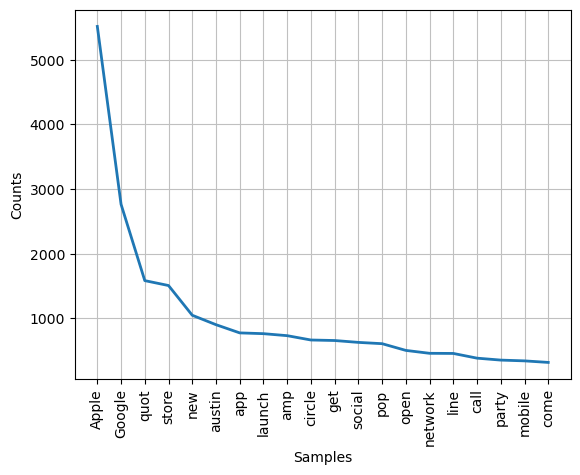

In [198]:

#Plot the 10 most common words
freq_dist.plot(20)
plt.show();

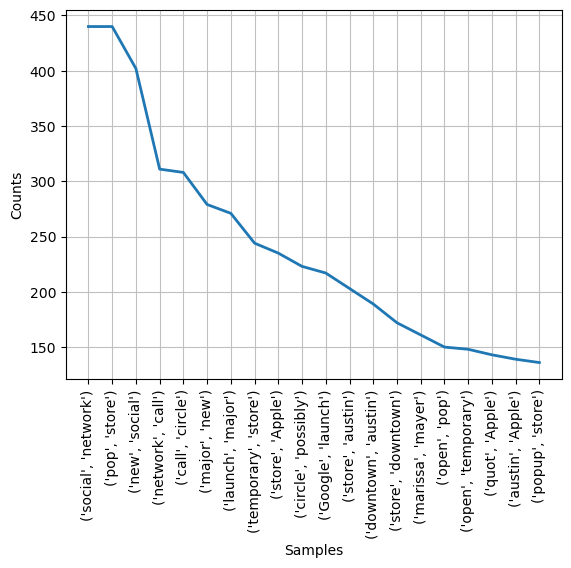

<Axes: xlabel='Samples', ylabel='Counts'>

In [199]:
bigrams = nltk.bigrams(all_words)
tokenized_bigrams = nltk.FreqDist(bigrams)
tokenized_bigrams.most_common(20)
tokenized_bigrams.plot(20)

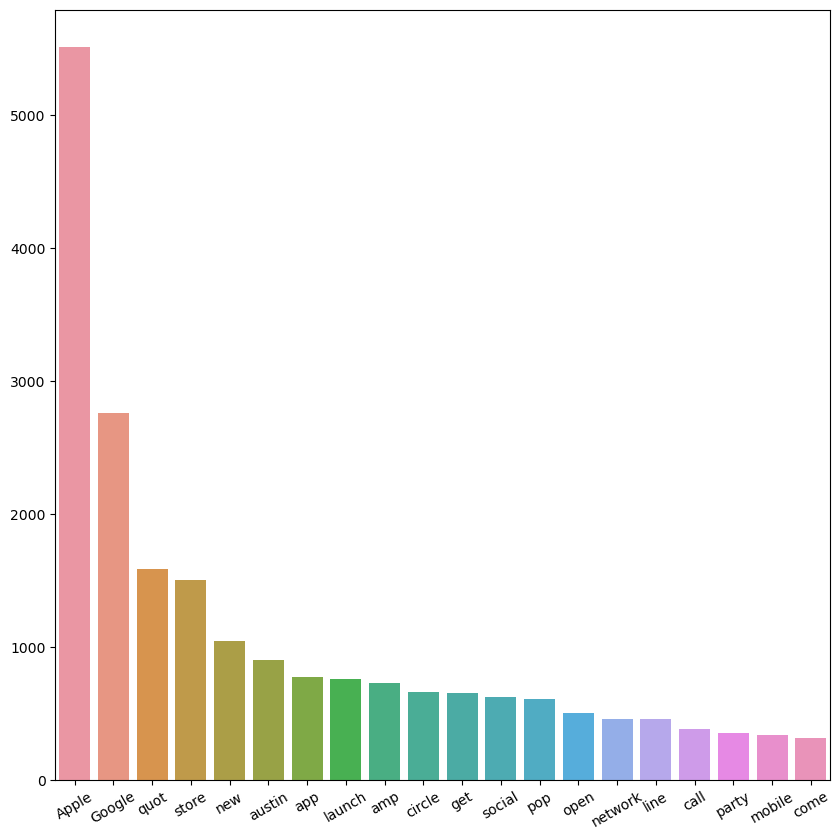

In [200]:
# Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = FreqDist(all_words).most_common(20)

# Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

# Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

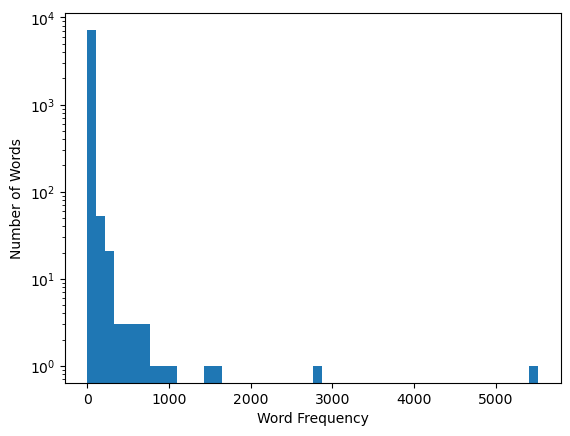

In [201]:
# Vectorize the text
vectorizer = CountVectorizer()
corpse = ()
X = vectorizer.fit_transform(data['text_with_product'])

# Sum the word frequencies
word_freq = X.sum(axis=0)

# Convert to a numpy array and flatten
word_freq = word_freq.A1

# Plot the distribution
plt.hist(word_freq, bins=50, log=True)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.show();

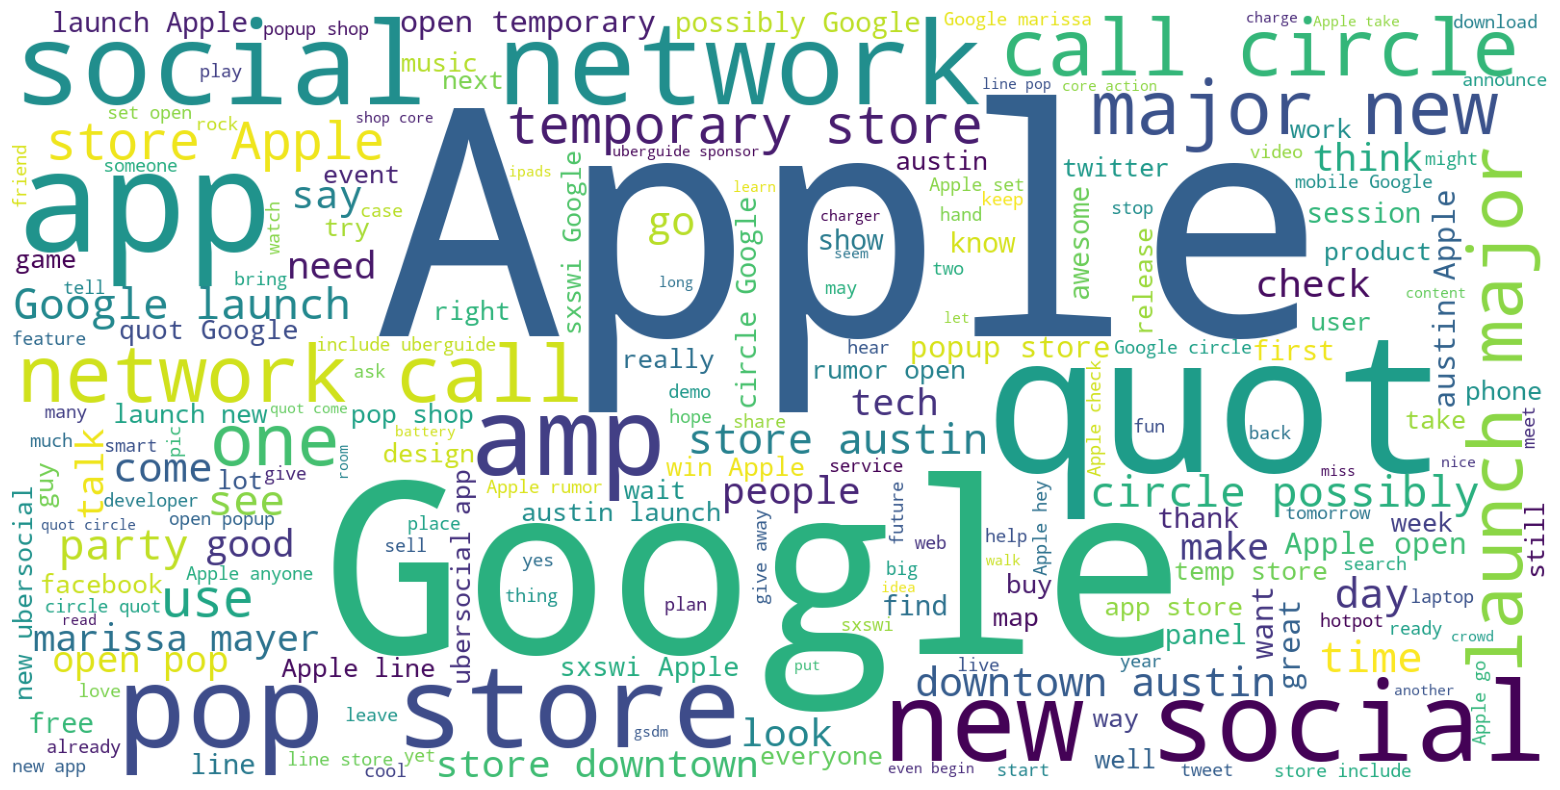

<Figure size 640x480 with 0 Axes>

In [202]:
#Convert word list to a single string
words_string = " ".join(all_words)

#generating the wordcloud
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(words_string)

#plot the wordcloud
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)

#to remove the axis value
plt.axis("off")
plt.show();

plt.savefig("cloudword.png")

# Train test split and evaluation metrics

In [203]:
# Assign the concatenated text to X
X = data['text_with_product']

# Assign the target labels to y
y = data['sentiment']

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [229]:
class EvaluationMetrics:
    def __init__(self, pipe, X_train, X_test, y_train, y_test):
        self.pipe = pipe
        self.X_train = X_train
        self.X_test= X_test
        self.y_train = y_train
        self.y_test = y_test

    def print_scores(self):
        # Training set predictions
        y_train_pred = self.pipe.predict(self.X_train)
        train_results_dict = {'accuracy': accuracy_score(self.y_train, y_train_pred),
                              'recall': recall_score(self.y_train, y_train_pred, average='weighted'),
                              'precision': precision_score(self.y_train, y_train_pred, average='weighted'),
                              'f1_score': f1_score(self.y_train, y_train_pred, average='weighted')}

        
        y_test_pred = self.pipe.predict(X_test)
        test_results_dict = {'accuracy': accuracy_score(y_test, y_test_pred),
                         'recall': recall_score(y_test, y_test_pred, average='weighted'),
                         'precision': precision_score(y_test, y_test_pred, average='weighted'),
                         'f1_score': f1_score(y_test, y_test_pred, average='weighted')}

        return train_results_dict, test_results_dict
        
    def cross_validation(self, cv=5):
        scores = cross_val_score(self.pipe, self.X_test, self.y_test, cv=cv, scoring='accuracy')
        return np.mean(scores), np.std(scores)
        
     # Plots roc curve for all classes 
    def plot_roc_curve_ovr(self):
        # Calculate FPR and TPR for each class (One-vs-Rest)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        n_classes = y_test_pred_proba.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y_test, y_test_pred_proba[:, i], pos_label=i)

        # Plot ROC curve for each class (One-vs-Rest)
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - One-vs-Rest')
        plt.legend(loc="lower right")
        plt.show()
    # Plots confussion matrix
    def plot_confusion_matrix(self, y_test, y_test_pred):
        cm = confusion_matrix(y_test, y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

# Logistic regression

In [230]:
lrpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('logreg', LogisticRegression(random_state=42, ))
])

# Fit the pipeline to the training data
lrpipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('logreg', LogisticRegression(random_state=42))])

Training Set Metrics:
accuracy: 0.856682769726248
recall: 0.856682769726248
precision: 0.8718864098976451
f1_score: 0.8374482055192215

Test set results:
accuracy: 0.6880733944954128
recall: 0.6880733944954128
precision: 0.6913703008752123
f1_score: 0.6604043695789253

cv set results:
Mean Accuracy: 0.6368837669518654
Standard Deviation of Accuracy: 0.01158771743514423


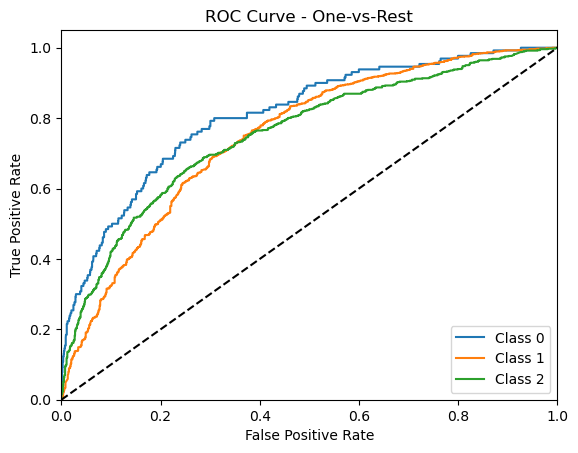

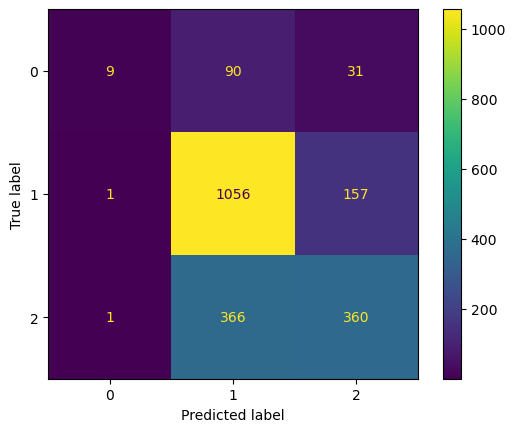

In [234]:
eval_metrics = EvaluationMetrics(lrpipe, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = eval_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = eval_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
eval_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_test_pred = eval_metrics.pipe.predict(X_test)
eval_metrics.plot_confusion_matrix(y_test, y_test_pred)

# Logistic Regression using CountVectorizer

In [236]:
lrpipe2 = Pipeline([
    ('vect', CountVectorizer(min_df=0.05, max_df=0.95)),
    ('logreg', LogisticRegression(random_state=42, ))
])

# Fit the pipeline to the training data
lrpipe2.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('logreg', LogisticRegression(random_state=42))])

Training Set Metrics:
accuracy: 0.5811594202898551
recall: 0.5811594202898551
precision: 0.5151416274363538
f1_score: 0.4882220671784914

Test set results:
accuracy: 0.5895702559150169
recall: 0.5895702559150169
precision: 0.5232866584016896
f1_score: 0.5015414730956146

cv set results:
Mean Accuracy: 0.5861859030324196
Standard Deviation of Accuracy: 0.011230396971943576


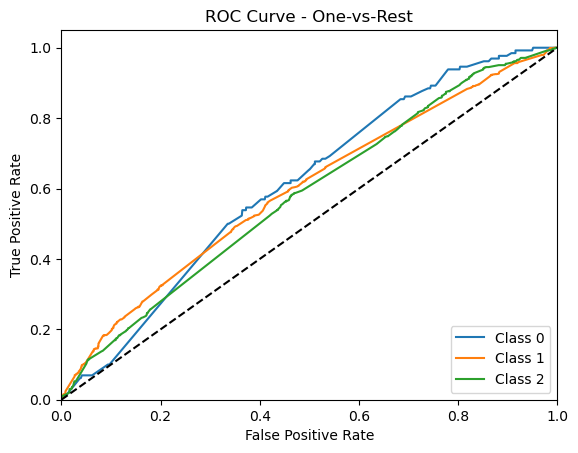

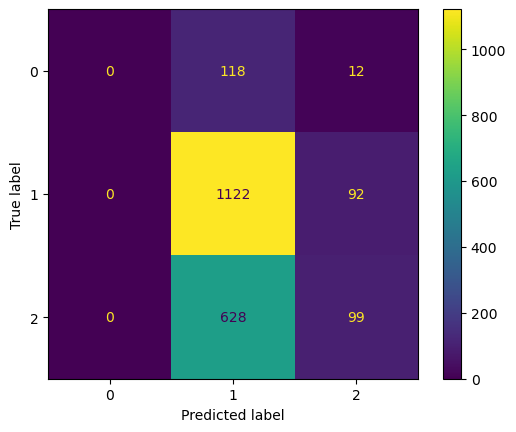

In [237]:
eval_metrics = EvaluationMetrics(lrpipe2, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = eval_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = eval_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
eval_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_test_pred = eval_metrics.pipe.predict(X_test)
eval_metrics.plot_confusion_matrix(y_test, y_test_pred)

# Baseline Model, MultinomialNB

In [209]:
mnbpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('mnb', MultinomialNB())
])

# Fit the pipeline to the training data
mnbpipe.fit(X_t, y_t)

Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('mnb', MultinomialNB())])

Training Set Metrics:
accuracy: 0.818552716340992
recall: 0.818552716340992
precision: 0.8523306953902132
f1_score: 0.7869674523853173

Validation Set Metrics:
accuracy: 0.652929813264649
recall: 0.652929813264649
precision: 0.6874011066162077
f1_score: 0.5892077500687446


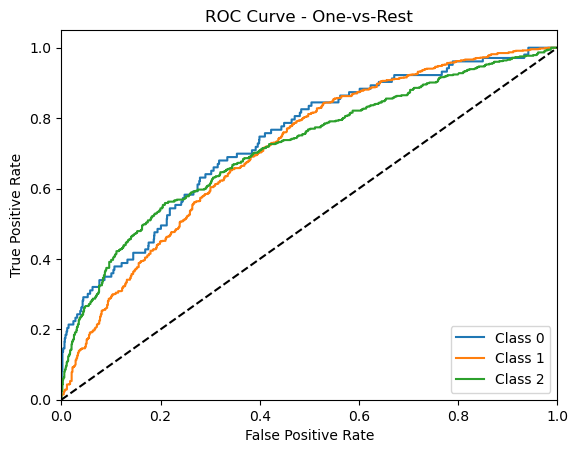

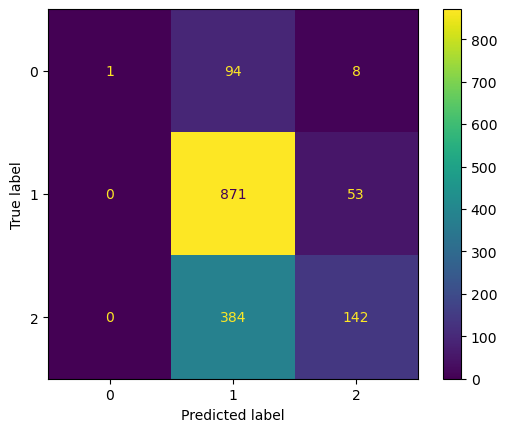

In [210]:
eval_metrics = EvaluationMetrics(mnbpipe, X_t, X_val, y_t, y_val)

# Print the evaluation metrics
train_results, val_results = eval_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")
print("\nValidation Set Metrics:")
for metric, score in val_results.items():
    print(f"{metric}: {score}")

# Plot the ROC curve
eval_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_val_pred = eval_metrics.pipe.predict(X_val)
eval_metrics.plot_confusion_matrix(y_val, y_val_pred)

# Balanced MultinomialNB

In [235]:
# Create an instance of RandomOverSampler
# oversampler = RandomOverSampler()

# # Resample the data
# X_resampled, y_resampled = oversampler.fit_resample(X_t, y_t)



# # Create and fit the MultinomialNB model
# mnb1 = MultinomialNB()
# mnb1.fit(X_resampled, y_resampled

In [ ]:
# y_t_pred_mnb1 = mnb1.predict(X_t_vec)

# Smote with MultinomialNB

# LogisticRegression

# CNN

In [ ]:
# model = models.Sequential()

# model.add(layers.Conv2D(filters=32,
#                         kernel_size=(3, 3),
#                         activation='relu',
#                         input_shape=(28, 28, 1)))

# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# RNN

In [ ]:
# X_t_vec_dense = X_t_vec.toarray()
# X_val_vec_dense = X_val_vec.toarray()

In [ ]:
# K.clear_session()

# # Calculate class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(y_t), y=y_t)

# # Define the RNN model
# embedding_dim = 200  
# lstm_units = 32  # 
# num_classes = len(np.unique(y_t))  
# batch_size = 32  
# epochs = 20  

# model = Sequential()
# model.add(Embedding(input_dim=X_t_vec_dense.shape[1], output_dim=embedding_dim, input_length=X_t_vec_dense.shape[1]))
# model.add(LSTM(units=lstm_units))
# model.add(Dense(units=num_classes, activation='softmax'))


# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# unique_classes = np.unique(y_t)
# class_weights_dict = {}
# for class_index in unique_classes:
#     class_weights_dict[class_index] = class_weights[class_index]

# model.fit(X_t_vec_dense, y_t, batch_size=batch_size, epochs=epochs, validation_data=(X_val_vec_dense, y_val), class_weight=class_weights_dict)

In [ ]:
# Define the model-building function
# K.clear_session()
# def build_model(hp):
#     model = Sequential()
#     model.add(Embedding(input_dim=X_t_vec_dense.shape[1], output_dim=hp.Int('embedding_dim', min_value=50, max_value=300, step=50), input_length=X_t_vec_dense.shape[1]))
#     model.add(LSTM(units=hp.Int('lstm_units', min_value=64, max_value=256, step=64)))
#     model.add(Dense(units=num_classes, activation='softmax'))
#     model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

# # Define the tuner
# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=5,  
#     executions_per_trial=1,
#     directory='my_dir',
#     project_name='my_project'
# )

# # Perform the hyperparameter search
# tuner.search(X_t_vec_dense, y_t, validation_data=(X_val_vec_dense, y_val), epochs=20, batch_size=32)

# # Get the best hyperparameters
# best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# best_model = tuner.hypermodel.build(best_hp)


In [ ]:
#How to pull a specific predictor out

In [ ]:
# Our baseline model is not bad, performance at 0.689 with TFIDF

In [ ]:
# Grid search and Modeling

In [ ]:
# # Define the MNB pipeline
# nbpipe = Pipeline([
#     ('vect', TfidfVectorizer(ngram_range=(1, 2))),
#     ('clf', MultinomialNB())
# ])

# # Fit the pipeline to the training data
# nbpipe.fit(X_t, y_t)

In [ ]:

# # Specify hyperparameters and their distributions
# parameters = {
#     'vect__ngram_range': [(1,1), (1,2), (2,2)],
#     'vect__max_df': [0.5, 0.75, 1.0],
#     'vect__min_df': [0.01, 0.05, 0.1],
#     'vect__max_features': [500, 1000, 20],
#     'vect__stop_words': [None, 'english'],
#     'vect__analyzer': ['word', 'char', 'char_wb'],
#     'clf__alpha': [0.0, 0.5, 1.0, 2.0],
#     'clf__fit_prior': [True, False]
# }

In [ ]:
# Instantiate GridSearchCV object using the lrpipe pipeline
# grid_search = GridSearchCV(nbpipe, parameters, n_jobs=-1, cv=5)

# # Fit on data
# grid_search.fit(X_t, y_t)

In [ ]:
# # Get the best parameters
# best_params = grid_search.best_params_
# best_params

In [ ]:
# y_t_gr = grid_search.predict(X_t)
# y_t_pred_gr= grid_search.predict(X_val)

# print("Accuracy:")
# train_accuracy = accuracy_score(y_t, y_t_gr)
# print("Train Accuracy:", train_accuracy)

# test_accuracy = accuracy_score(y_val, y_t_pred_gr)
# print("Test Accuracy:", test_accuracy)

# print("\nBalanced Accuracy:")
# train_accuracy = balanced_accuracy_score(y_t, y_t_gr)
# print("Train Accuracy:", train_accuracy)

# test_accuracy = balanced_accuracy_score(y_val, y_t_pred_gr)
# print("Test Accuracy:", test_accuracy)